In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tiktoken

from utilities.gpt_module import GPTModel
import importlib
from utilities import supporting_modules
from utilities.supporting_modules import create_dataloader, GPTDataset

from utilities.supporting_modules import cross_entropy_batch_loss, loss_calculator

In [3]:
gpt_config_124m = {
"vocab_size": 50257,
"context_length": 256, #A
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1, #B
"qkv_bias": False
}

##### Text generation Helping functions
A three-step text generation process using a GPT model:
- First, the tokenizer converts input text into a series of token IDs,
- Second, the model receives these token IDs and generates corresponding logits, which are vectors representing the probability distribution for each token in the vocabulary.
- Third, these logits are converted back into token IDs, which the tokenizer decodes into human-readable text, completing the cycle from textual input to textual output.

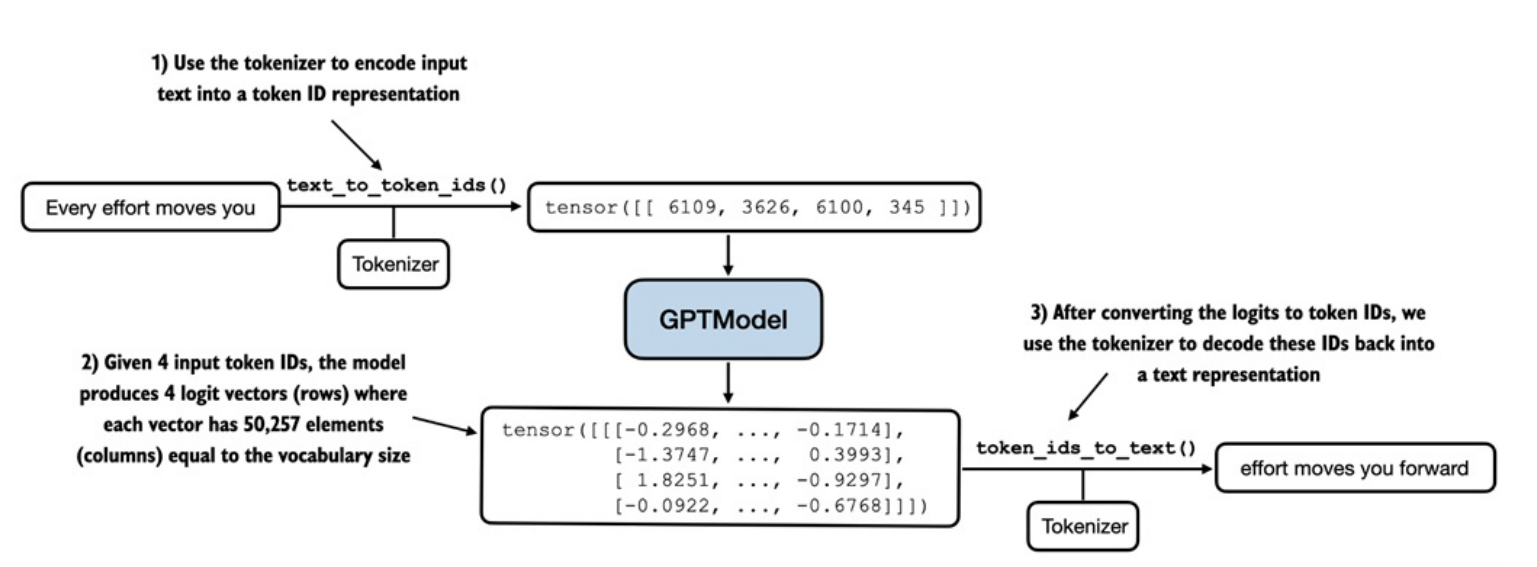

In [4]:

def generate_text(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :] #C
        probas = torch.softmax(logits, dim=-1) #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) #E
        idx = torch.cat((idx, idx_next), dim=1) #F
    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # to add batch dimension
    return encoded_tensor
    
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # to remove batch dimension
    return tokenizer.decode(flat.tolist())

### Setting the data

In [5]:
file_path = "data/the_verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# crafting data loaders
train_loader = create_dataloader(
train_data,
batch_size=2,
max_length=gpt_config_124m["context_length"],
stride=gpt_config_124m["context_length"],
drop_last=True,
shuffle=True
)
val_loader = create_dataloader(
val_data,
batch_size=2,
max_length=gpt_config_124m["context_length"],
stride=gpt_config_124m["context_length"],
drop_last=False,
shuffle=False
)

### Training Function

In [79]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(model=model, idx=encoded,
        max_new_tokens=50, context_size=context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() #A
    with torch.no_grad(): #B
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [80]:
def train_model(model, train_loader, val_loader, optimizer, 
               eval_freq, eval_iter, num_epochs, start_context):
    train_losses, val_losses, track_token_seens = [],[], []
    tokens_seen, global_step = 0,-1
    for epoch in rang(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_calculator(train_loader, model, cross_entropy_batch_loss, device)
            loss.backward()
            optimizer.step()

            tokens_seen +=input_batch.numel()
            global_step+=1
            if global_step%eval_freq==0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch: {epoch+1} (Step: {global_step: 06d}):", 
                     f"Train loss: {train_loss: .3f}, Val loss: {val_loss: .3f}")
            generate_and_print_sample( model, train_loader.dataset.tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen
                

In [7]:
torch.manual_seed(123)
model = GPTModel(gpt_config_124m)



In [ ]:
device='cpu'
model.to(device)
loss = loss_calculator(train_loader, model, cross_entropy_batch_loss, device)
loss

In [121]:
def cross_entropy_batch_loss(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def loss_calculator(data_loader, model, loss_function, device, num_batches=None):
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader) # A
    else:
        num_batches = min(num_batches, len(data_loader)) # B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = loss_function(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    return total_loss / num_batches

In [101]:
a=[2,4,5]
torch.tensor(a,)

torch.Size([2, 256])

In [96]:
loss.backward()

AttributeError: 'float' object has no attribute 'backward'

In [115]:
criterion=nn.CrossEntropyLoss()
def loss_calculator2(train_loader, model, criterion, device):
    # Dummy implementation for the sake of example
    # model.train()
    for data, target_batch in train_loader:
        data, target_batch = data.to(device), target_batch.to(device)
        # optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits.flatten(0, 1), target_batch.flatten())

        return loss

In [117]:
loss2.backward()